# TODO
- use pipenv (when i'll have a box)
- create a blog or a medium (in french !)

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def display(cv_img):
    plt.figure(figsize = (7, 7)) 
    plt.imshow(cv_img, cmap='gray')
    plt.axis('off')
    plt.show()    

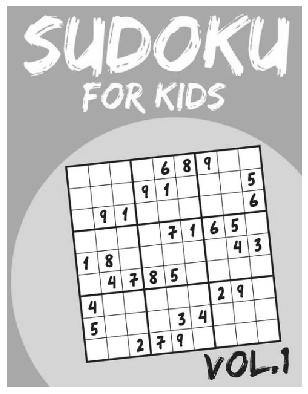

In [3]:
img = cv.imread("./img/cover.jpg")
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY) 
display(gray)

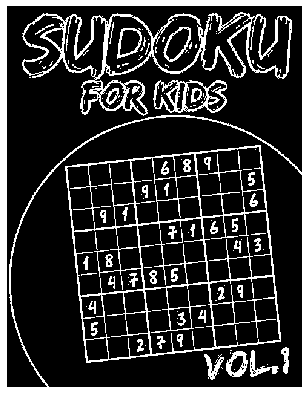

In [7]:
#blur = cv.GaussianBlur(img, (9, 9), 0)
blur = cv.fastNlMeansDenoising(gray)
#ret, thresh = cv.threshold(img, 127, 255, cv.THRESH_BINARY) # not adapted
thresh = cv.adaptiveThreshold(blur, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 11, 2)
display(thresh)

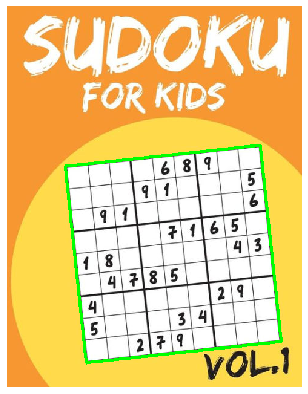

In [539]:
# the RETR_EXTERNAL mode is used to limit the search to only extreme outer contours skipping 
# any that lie inside other contours.
contours, hierarchy = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cnt = sorted(contours, key=lambda c: cv.contourArea(c), reverse=True)[0]

cnt_im = img.copy()
cv.drawContours(cnt_im, [cnt], 0, (0,255,0), 3)

plt.figure(figsize = (7, 7)) 
plt.imshow(cv.cvtColor(cnt_im, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()    

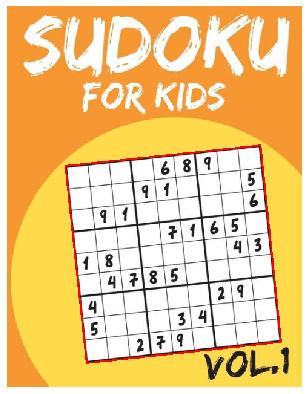

In [540]:
approx = cv.approxPolyDP(cnt, 0.009 * cv.arcLength(cnt, True), closed=True)

rect_im = img.copy()
cv.drawContours(rect_im, [approx.astype("int")], -1, (0, 0, 255), 2)

plt.figure(figsize = (7, 7)) 
plt.imshow(cv.cvtColor(rect_im, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()    

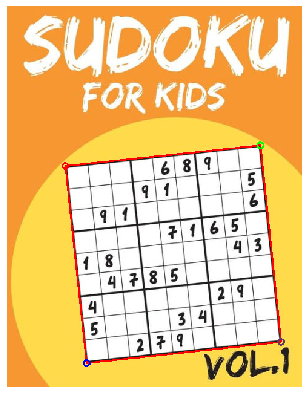

In [541]:
assert len(approx) == 4

pts = [
    tuple(approx[0][0]),
    tuple(approx[1][0]),
    tuple(approx[2][0]),
    tuple(approx[3][0])
]

right_pts = sorted(pts, key=lambda c: c[0])[:2]
left_pts = sorted(pts, key=lambda c: c[0])[2:]
right_pts = sorted(right_pts, key=lambda c: c[1])
left_pts = sorted(left_pts, key=lambda c: c[1])

# sorted points
im_pts = np.float32([
    right_pts[0],
    left_pts[0],
    right_pts[1],
    left_pts[1]
])

(tl, tr, br, bl) = im_pts

pts_im = rect_im.copy()
cv.circle(pts_im, tuple(im_pts[0]), 5, (0, 0, 255), 2)
cv.circle(pts_im, tuple(im_pts[1]), 5, (0, 255, 0), 2)
cv.circle(pts_im, tuple(im_pts[2]), 5, (255, 0, 0), 2)
cv.circle(pts_im, tuple(im_pts[3]), 5, (100, 55, 100), 2)
    
plt.figure(figsize = (7, 7)) 
plt.imshow(cv.cvtColor(pts_im, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()  

array([54., 63.], dtype=float32)

In [542]:
# https://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/
L = int(np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))) # could do a mean
dst_pts = np.float32([
    [0, 0],
    [L - 1, 0],
    [0, L - 1],
    [L - 1, L - 1],
])
M = cv.getPerspectiveTransform(im_pts, dst_pts)

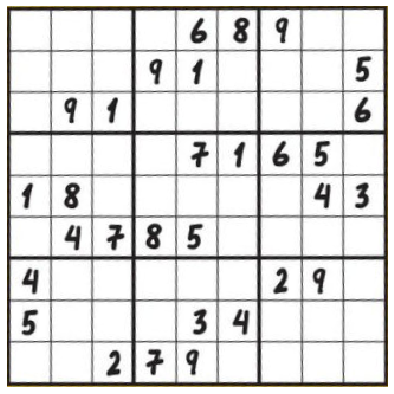

In [543]:
warped = cv.warpPerspective(img, M, (L, L))

plt.figure(figsize = (7, 7)) 
plt.imshow(cv.cvtColor(warped, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()  

In [544]:
gray = cv.cvtColor(warped, cv.COLOR_BGR2GRAY) 
blur = cv.fastNlMeansDenoising(gray)
thresh = cv.adaptiveThreshold(blur, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 11, 2)

In [545]:
warped.shape[0] / (9+3)

26.833333333333332

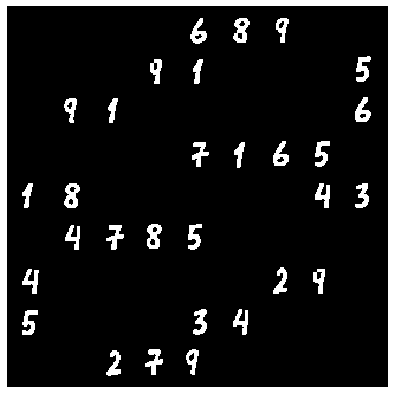

In [546]:
horizontal_kernel = cv.getStructuringElement(cv.MORPH_RECT, (23, 1)) # 23 => 1/9 de l'image ?
horizontal_mask = cv.erode(thresh, horizontal_kernel)
horizontal_mask = cv.dilate(horizontal_mask, horizontal_kernel)

vertical_kernel = cv.getStructuringElement(cv.MORPH_RECT, (1, 23)) # 23 => 1/9 de l'image ?
vertical_mask = cv.erode(thresh, vertical_kernel)
vertical_mask = cv.dilate(vertical_mask, vertical_kernel)

numbers = cv.subtract(thresh, horizontal_mask);
numbers = cv.subtract(numbers, vertical_mask);

numbers = cv.erode(numbers, None, iterations=1)
numbers = cv.dilate(numbers, None)

plt.figure(figsize = (7, 7)) 
plt.imshow(cv.cvtColor(numbers, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()  

In [518]:
height, width, channels = warped.shape
# Number of pieces Horizontally 
CROP_W_SIZE  = 9 
# Number of pieces Vertically to each Horizontal  
CROP_H_SIZE = 9 

cropped = []
for ih in range(CROP_H_SIZE ):
    for iw in range(CROP_W_SIZE ):

        x = int(width/CROP_W_SIZE * iw)
        y = int(height/CROP_H_SIZE * ih)
        h = int(height / CROP_H_SIZE)
        w = int(width / CROP_W_SIZE )
        #print(x,y,h,w)
        cropped.append(numbers[y:y+h, x:x+w])        

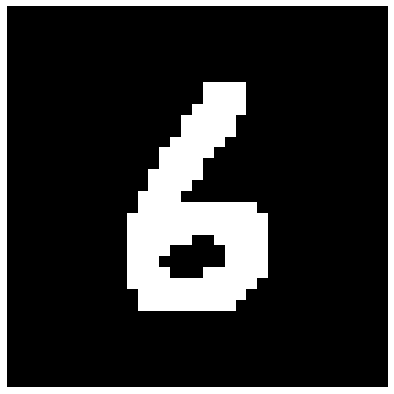

In [523]:
plt.figure(figsize = (7, 7)) 
plt.imshow(cv.cvtColor(cropped[33], cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()  

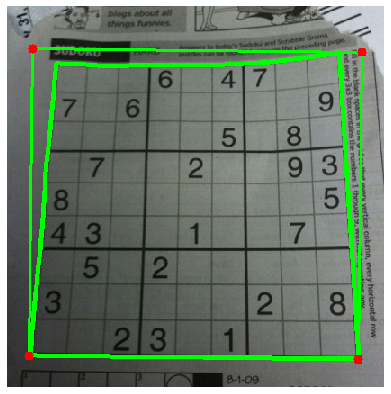

In [203]:
rect = cv.minAreaRect(cnt)
box = cv.boxPoints(rect) # float values
box = np.array(box, dtype="int") # cast to int (round) for pixels

rect_im = cv.drawContours(cnt_im, [box.astype("int")], -1, (0, 255, 0), 2)

for (x, y) in box:
    rect_im = cv.circle(rect_im, (int(x), int(y)), 5, (0, 0, 255), -1)
    
plt.figure(figsize = (7, 7)) 
plt.imshow(cv.cvtColor(rect_im, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()  